# IML PROJECT

# RETINAL IMAGE CLASSIFICATION

## 1. Loading the Libraries and the Dataset

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

import kagglehub
path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")
print("Dataset path:", path)

Dataset path: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1


In [ ]:
class RetinalDataset(Dataset):
  def __init__(self, base_dir, split = 'training', transform = None) -> None:
    super().__init__()
    self.base_dir = os.path.join(base_dir, "DRIVE")
    self.split = split
    self.transform = transform

    self.image_dir = os.path.join(self.base_dir, split, 'images')
    self.mask_dir = os.path.join(self.base_dir, split, '1st_manual')
    self.files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.tif')])

    self.dr_cases = {
            'training': ['25_training.tif', '26_training.tif', '32_training.tif'],
            'test': ['03_test.tif', '08_test.tif', '14_test.tif', '17_test.tif']
    }

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    image_path = os.path.join(self.image_dir, self.files[idx])
    image = Image.open(image_path).convert('RGB')

    label = 1.0 if self.files[idx] in self.dr_cases.get(self.split, []) else 0.0

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label, dtype=torch.float32)

def get_transforms(split):
    if split == 'training':
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


### VGGNet Architecture

In [ ]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG-style convolutional blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### ResNet Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2]):  # ResNet18 configuration
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#### model training

In [ ]:
def train_model(model, train_loader, test_loader, model_name, num_epochs=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_acc = 100 * correct / total

        # Update scheduler
        scheduler.step(val_acc)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')

    return history

## 3. Vizualization

In [ ]:
def plot_training_history(history, model_name):
    """Helper function to plot training history"""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, model_name):
    """
    Visualize predictions for all test images with clear labels and confidence scores
    """
    device = next(model.parameters()).device
    model.eval()

    # Dictionary of known DR cases and their descriptions
    dr_case_descriptions = {
        '03_test.tif': 'Background diabetic retinopathy',
        '08_test.tif': 'Pigment epithelium changes, pigmented scar in fovea',
        '14_test.tif': 'Background diabetic retinopathy',
        '17_test.tif': 'Background diabetic retinopathy'
    }

    all_images = []
    all_labels = []
    all_predictions = []
    all_confidences = []
    all_filenames = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float().cpu()

            # Store batch results
            all_images.extend(images.cpu())
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            all_confidences.extend(outputs.cpu())

            # Get filenames
            batch_filenames = [test_loader.dataset.files[idx] for idx in range(
                batch_idx * test_loader.batch_size,
                min((batch_idx + 1) * test_loader.batch_size, len(test_loader.dataset))
            )]
            all_filenames.extend(batch_filenames)

    # Calculate metrics
    total = len(all_labels)
    correct = sum((p.item() == l.item()) for p, l in zip(all_predictions, all_labels))
    accuracy = correct / total

    # Create visualization
    num_images = len(all_images)
    rows = (num_images + 3) // 4  # 4 images per row
    plt.figure(figsize=(20, 5 * rows))

    # Add title with overall accuracy
    plt.suptitle(f'{model_name} Predictions on Test Set (Accuracy: {accuracy:.2%})',
                 fontsize=16, y=0.95)

    for idx in range(num_images):
        plt.subplot(rows, 4, idx + 1)

        # Denormalize image
        img = all_images[idx].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        plt.imshow(img.numpy())
        plt.axis('off')

        # Get prediction details
        filename = all_filenames[idx]
        true_label = all_labels[idx].item()
        pred_label = all_predictions[idx].item()
        confidence = all_confidences[idx].item()

        # Create title
        title = f"File: {filename}\n"
        title += f"Prediction: {'DR' if pred_label == 1 else 'Normal'} ({confidence:.2%} conf)\n"
        title += f"True: {'DR' if true_label == 1 else 'Normal'}\n"

        # Add diagnosis if available
        if filename in dr_case_descriptions:
            title += f"\nDiagnosis:\n{dr_case_descriptions[filename]}"

        # Color code based on correctness
        color = 'green' if pred_label == true_label else 'red'
        plt.title(title, color=color, fontsize=10, pad=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def create_confusion_matrix(model, test_loader):
    device = next(model.parameters()).device
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float().cpu()

            all_predictions.extend(predicted)
            all_labels.extend(labels)

    # Create confusion matrix
    cm = np.zeros((2, 2))
    for pred, label in zip(all_predictions, all_labels):
        cm[int(pred.item())][int(label.item())] += 1

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Normal', 'DR'],
                yticklabels=['Normal', 'DR'])
    plt.title('Confusion Matrix')
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def analyze_model_performance(model, test_loader):
    """
    Comprehensive analysis of model performance including clinical metrics
    """
    device = next(model.parameters()).device
    model.eval()

    predictions = []
    labels = []
    confidences = []
    filenames = []

    with torch.no_grad():
        for batch_idx, (images, target) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            pred = (outputs > 0.5).float().cpu()

            predictions.extend(pred.numpy().flatten())
            labels.extend(target.numpy().flatten())
            confidences.extend(outputs.cpu().numpy().flatten())

            # Get filenames
            batch_filenames = [test_loader.dataset.files[idx] for idx in range(
                batch_idx * test_loader.batch_size,
                min((batch_idx + 1) * test_loader.batch_size, len(test_loader.dataset))
            )]
            filenames.extend(batch_filenames)

    # Calculate metrics
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    sensitivity = np.sum((np.array(predictions) == 1) & (np.array(labels) == 1)) / np.sum(np.array(labels) == 1)
    specificity = np.sum((np.array(predictions) == 0) & (np.array(labels) == 0)) / np.sum(np.array(labels) == 0)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Filename': filenames,
        'True_Label': labels,
        'Prediction': predictions,
        'Confidence': confidences
    })

    # Print metrics
    print("\nModel Performance:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Sensitivity: {sensitivity:.2%}")
    print(f"Specificity: {specificity:.2%}")

    return results_df

Using device: cuda

Dataset Summary:
Training images: 20
Test images: 20
Initialized ResNet model

Starting training...


Epoch 1/30: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 1/30:
Train Loss: 1.2024, Train Acc: 60.00%
Val Loss: 0.5989, Val Acc: 80.00%


Epoch 2/30: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Epoch 2/30:
Train Loss: 0.6728, Train Acc: 80.00%
Val Loss: 3.0292, Val Acc: 75.00%


Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch 3/30:
Train Loss: 0.4071, Train Acc: 80.00%
Val Loss: 16.8544, Val Acc: 75.00%


Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 4/30:
Train Loss: 0.3191, Train Acc: 90.00%
Val Loss: 16.7391, Val Acc: 80.00%


Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


Epoch 5/30:
Train Loss: 0.8028, Train Acc: 85.00%
Val Loss: 15.8080, Val Acc: 80.00%


Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Epoch 6/30:
Train Loss: 0.5518, Train Acc: 85.00%
Val Loss: 4.9103, Val Acc: 80.00%


Epoch 7/30: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Epoch 7/30:
Train Loss: 0.5698, Train Acc: 85.00%
Val Loss: 1.3753, Val Acc: 80.00%


Epoch 8/30: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Epoch 8/30:
Train Loss: 0.5010, Train Acc: 85.00%
Val Loss: 0.8350, Val Acc: 80.00%


Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Epoch 9/30:
Train Loss: 0.4990, Train Acc: 85.00%
Val Loss: 0.7105, Val Acc: 80.00%


Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Epoch 10/30:
Train Loss: 0.5290, Train Acc: 85.00%
Val Loss: 0.6640, Val Acc: 80.00%


Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Epoch 11/30:
Train Loss: 0.3606, Train Acc: 85.00%
Val Loss: 0.6764, Val Acc: 80.00%


Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch 12/30:
Train Loss: 0.4734, Train Acc: 85.00%
Val Loss: 0.7314, Val Acc: 80.00%


Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 13/30:
Train Loss: 0.6090, Train Acc: 85.00%
Val Loss: 0.6119, Val Acc: 80.00%


Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Epoch 14/30:
Train Loss: 0.4225, Train Acc: 85.00%
Val Loss: 0.5950, Val Acc: 80.00%


Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


Epoch 15/30:
Train Loss: 0.4380, Train Acc: 85.00%
Val Loss: 0.5847, Val Acc: 80.00%


Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Epoch 16/30:
Train Loss: 0.3423, Train Acc: 85.00%
Val Loss: 0.5493, Val Acc: 80.00%


Epoch 17/30: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Epoch 17/30:
Train Loss: 0.5773, Train Acc: 85.00%
Val Loss: 0.5425, Val Acc: 80.00%


Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


Epoch 18/30:
Train Loss: 0.5260, Train Acc: 85.00%
Val Loss: 0.5366, Val Acc: 80.00%


Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Epoch 19/30:
Train Loss: 0.4169, Train Acc: 85.00%
Val Loss: 0.5353, Val Acc: 80.00%


Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 20/30:
Train Loss: 0.4526, Train Acc: 85.00%
Val Loss: 0.5407, Val Acc: 80.00%


Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


Epoch 21/30:
Train Loss: 0.4182, Train Acc: 85.00%
Val Loss: 0.5503, Val Acc: 80.00%


Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Epoch 22/30:
Train Loss: 0.3700, Train Acc: 85.00%
Val Loss: 0.5444, Val Acc: 80.00%


Epoch 23/30: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 23/30:
Train Loss: 0.3445, Train Acc: 85.00%
Val Loss: 0.5402, Val Acc: 80.00%


Epoch 24/30: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 24/30:
Train Loss: 0.5683, Train Acc: 85.00%
Val Loss: 0.5400, Val Acc: 80.00%


Epoch 25/30: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 25/30:
Train Loss: 0.4422, Train Acc: 85.00%
Val Loss: 0.5399, Val Acc: 80.00%


Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 26/30:
Train Loss: 0.5167, Train Acc: 85.00%
Val Loss: 0.5468, Val Acc: 80.00%


Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Epoch 27/30:
Train Loss: 0.4764, Train Acc: 85.00%
Val Loss: 0.5490, Val Acc: 80.00%


Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Epoch 28/30:
Train Loss: 0.4394, Train Acc: 85.00%
Val Loss: 0.5516, Val Acc: 80.00%


Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Epoch 29/30:
Train Loss: 0.3430, Train Acc: 85.00%
Val Loss: 0.5500, Val Acc: 80.00%


Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Epoch 30/30:
Train Loss: 0.5128, Train Acc: 85.00%
Val Loss: 0.5515, Val Acc: 80.00%


<ipython-input-51-82d3c4beebcf>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


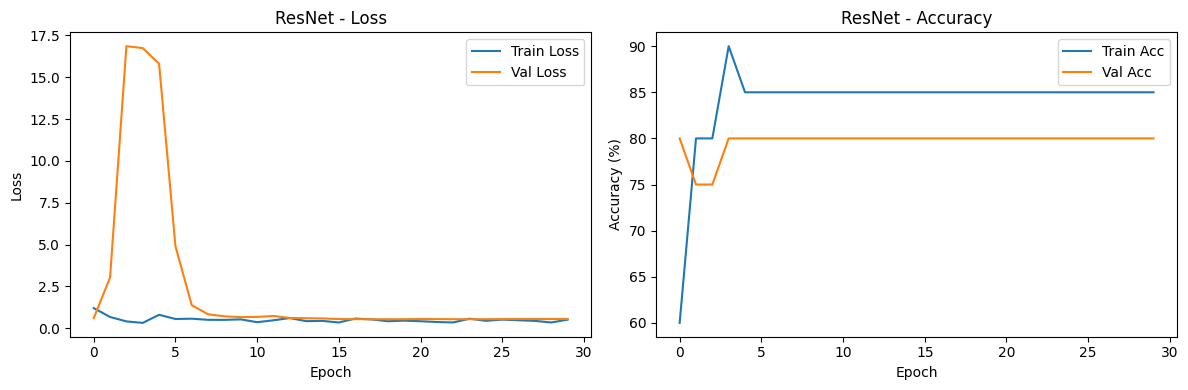


Generating prediction visualizations...


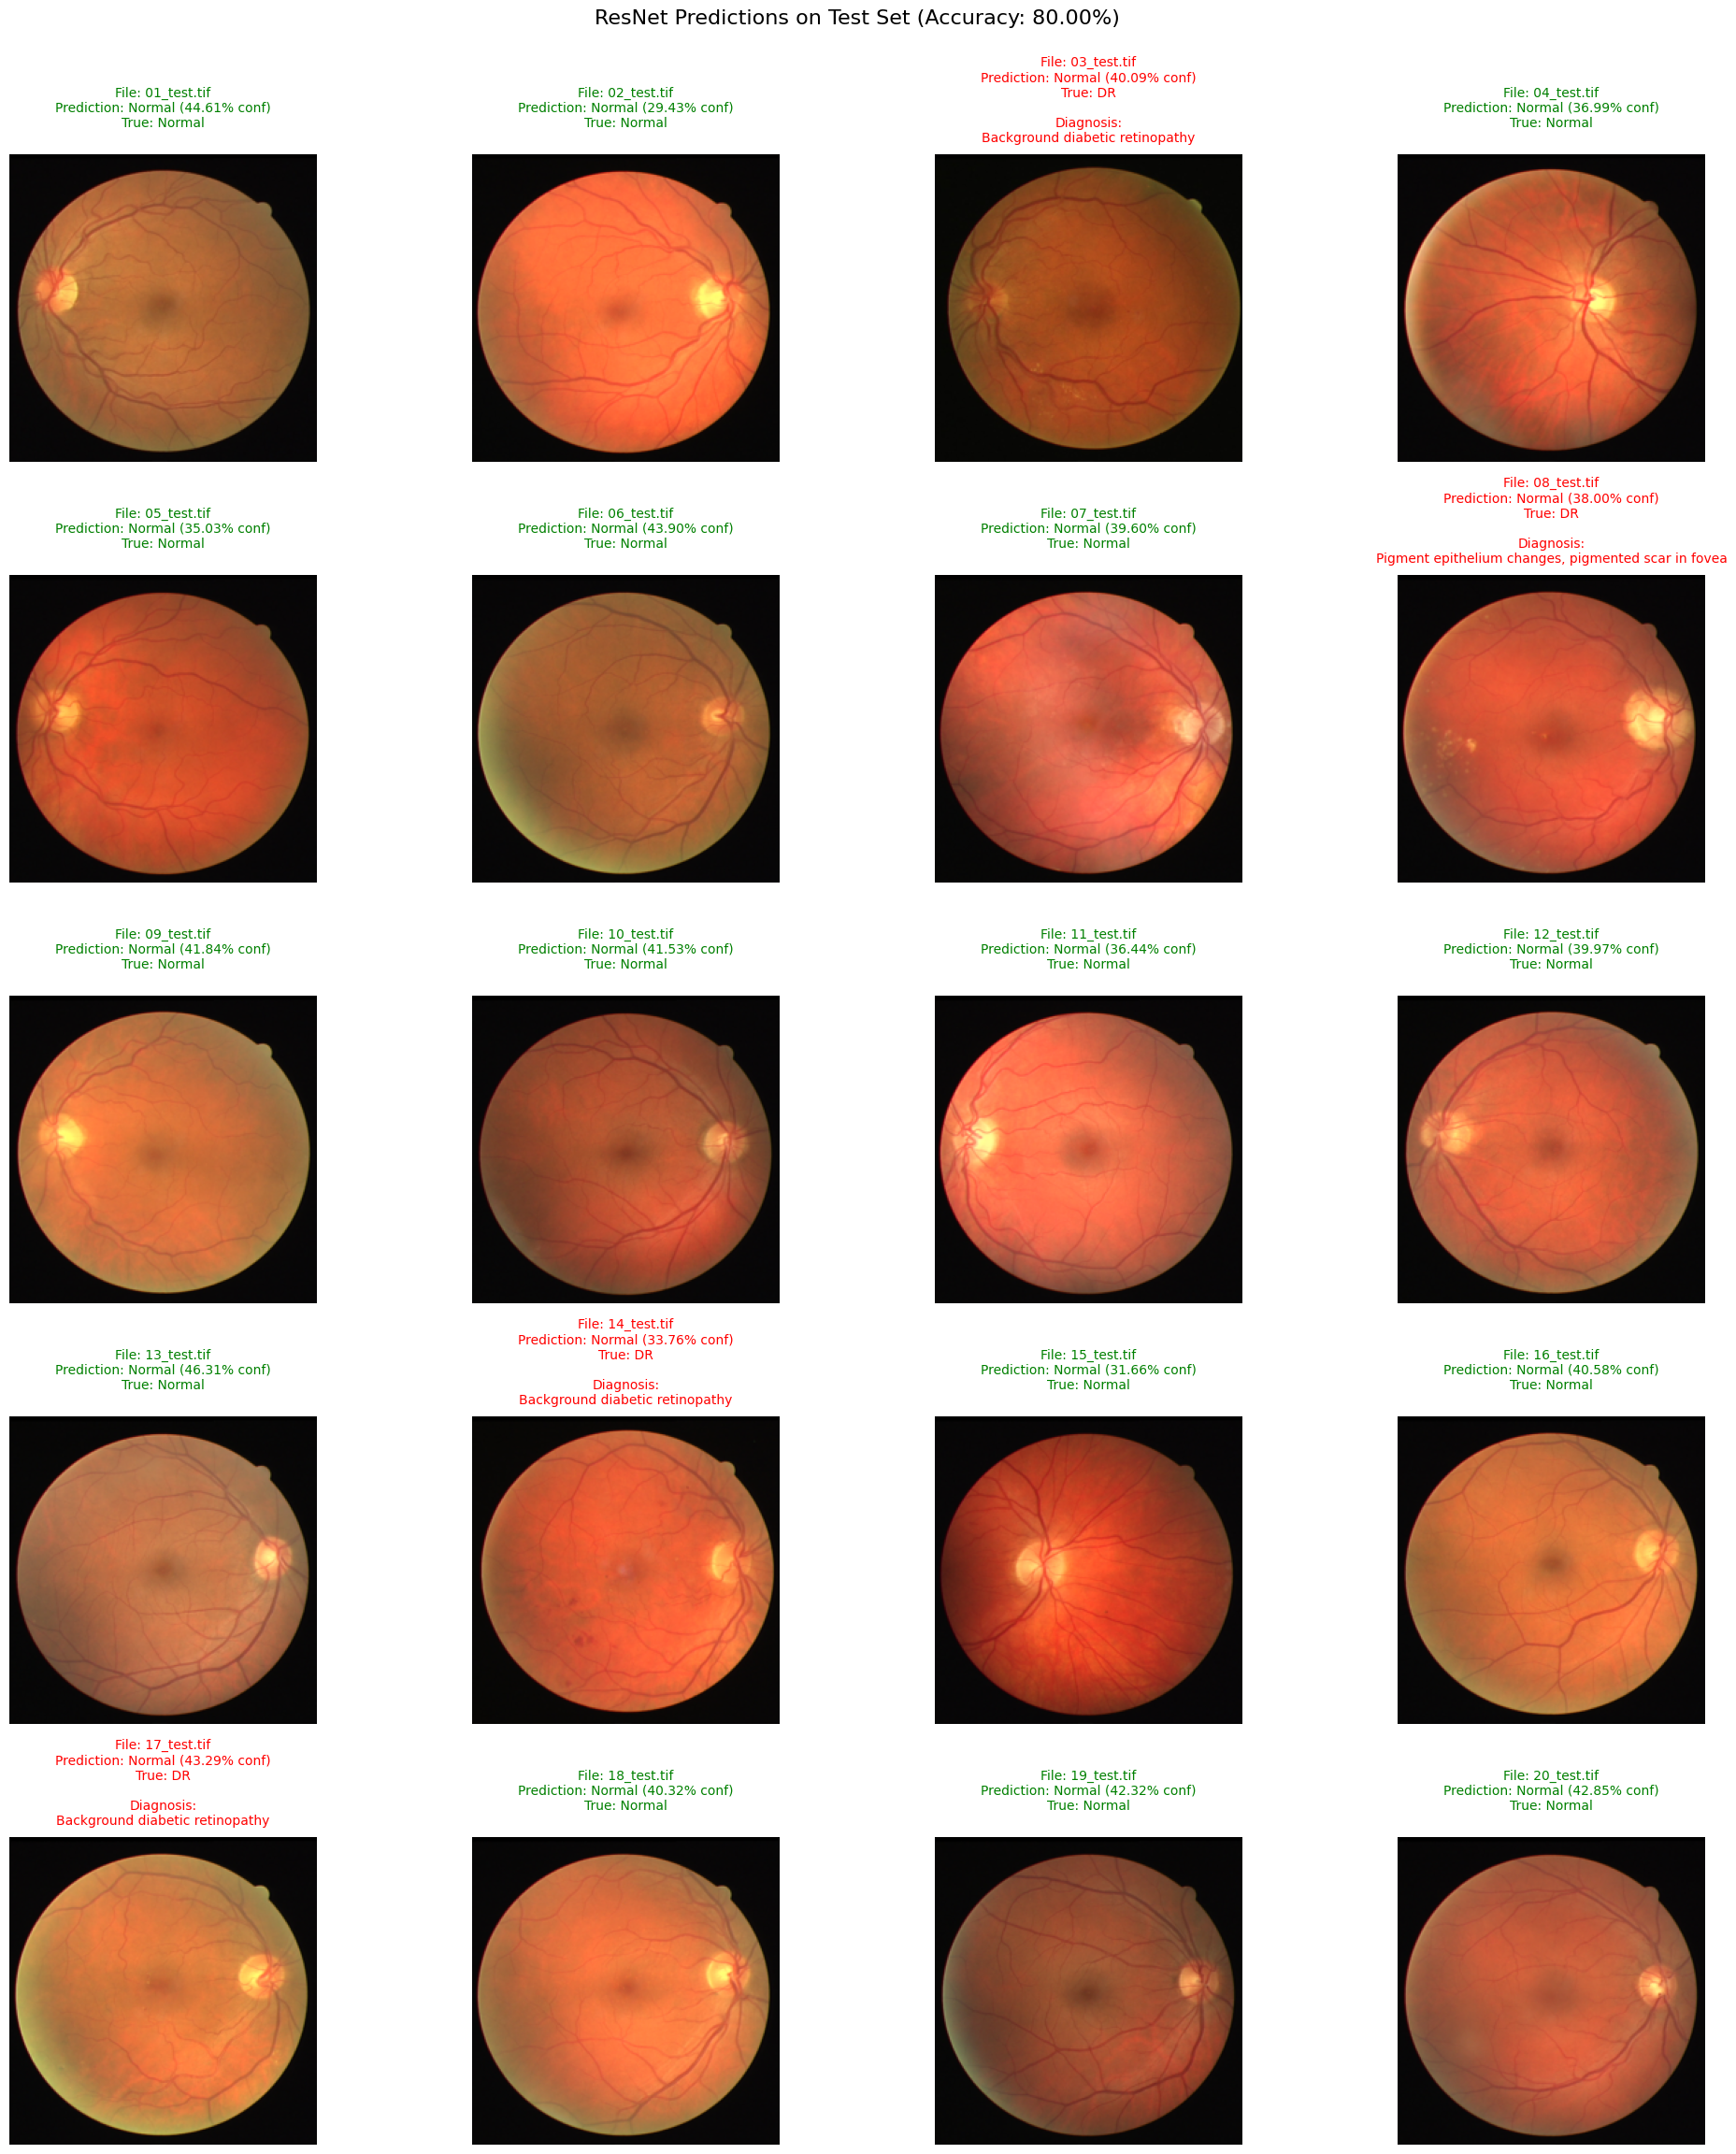


Model Performance:
Accuracy: 80.00%
Sensitivity: 0.00%
Specificity: 100.00%


In [ ]:
def main(data_path, model_type='resnet', batch_size=8, epochs=30):
    """
    Main function with visualization
    """
    # [Previous main function code remains the same until after model training]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize datasets and dataloaders
    train_dataset = RetinalDataset(
        base_dir=data_path,
        split='training',
        transform=get_transforms('training')
    )

    test_dataset = RetinalDataset(
        base_dir=data_path,
        split='test',
        transform=get_transforms('test')
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Print dataset information
    print(f"\nDataset Summary:")
    print(f"Training images: {len(train_dataset)}")
    print(f"Test images: {len(test_dataset)}")

    # Initialize model
    if model_type.lower() == 'vgg':
        model = VGGNet()
        model_name = 'VGG'
    else:
        model = ResNet()
        model_name = 'ResNet'

    model = model.to(device)
    print(f"Initialized {model_name} model")

    # Train model and get history
    print("\nStarting training...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        model_name=model_name,
        num_epochs=epochs
    )

    # Load best model weights
    best_model_path = f'best_model_{model_name}.pth'
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # Plot training history
    plot_training_history(history, model_name)

    # Visualize predictions
    print("\nGenerating prediction visualizations...")
    visualize_predictions(model, test_loader, model_name)

    # Analyze model performance
    results_df = analyze_model_performance(model, test_loader)

    return model, history, results_df

# Example usage
if __name__ == "__main__":
    model, history, results = main(
        data_path=path,  # Using the path from kagglehub download
        model_type='resnet',  # or 'vgg'
        batch_size=8,
        epochs=30
    )

Using device: cuda

Dataset Summary:
Training images: 20
Test images: 20
Initialized VGG model

Starting training...


Epoch 1/30: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epoch 1/30:
Train Loss: 0.7373, Train Acc: 55.00%
Val Loss: 0.5473, Val Acc: 80.00%


Epoch 2/30: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch 2/30:
Train Loss: 0.5109, Train Acc: 85.00%
Val Loss: 0.7111, Val Acc: 80.00%


Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 3/30:
Train Loss: 0.5399, Train Acc: 85.00%
Val Loss: 0.5365, Val Acc: 80.00%


Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 4/30:
Train Loss: 0.4640, Train Acc: 85.00%
Val Loss: 0.5273, Val Acc: 80.00%


Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 5/30:
Train Loss: 0.3937, Train Acc: 85.00%
Val Loss: 0.5404, Val Acc: 80.00%


Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 6/30:
Train Loss: 0.3831, Train Acc: 85.00%
Val Loss: 0.5545, Val Acc: 80.00%


Epoch 7/30: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 7/30:
Train Loss: 0.3965, Train Acc: 85.00%
Val Loss: 0.5617, Val Acc: 80.00%


Epoch 8/30: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 8/30:
Train Loss: 0.3968, Train Acc: 85.00%
Val Loss: 0.5412, Val Acc: 80.00%


Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 9/30:
Train Loss: 0.4624, Train Acc: 85.00%
Val Loss: 0.5352, Val Acc: 80.00%


Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 10/30:
Train Loss: 0.4551, Train Acc: 85.00%
Val Loss: 0.5275, Val Acc: 80.00%


Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 11/30:
Train Loss: 0.5092, Train Acc: 85.00%
Val Loss: 0.5187, Val Acc: 80.00%


Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 12/30:
Train Loss: 0.4576, Train Acc: 85.00%
Val Loss: 0.5124, Val Acc: 80.00%


Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 13/30:
Train Loss: 0.5427, Train Acc: 85.00%
Val Loss: 0.5118, Val Acc: 80.00%


Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 14/30:
Train Loss: 0.3926, Train Acc: 85.00%
Val Loss: 0.5119, Val Acc: 80.00%


Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 15/30:
Train Loss: 0.4105, Train Acc: 85.00%
Val Loss: 0.5119, Val Acc: 80.00%


Epoch 16/30: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 16/30:
Train Loss: 0.4032, Train Acc: 85.00%
Val Loss: 0.5136, Val Acc: 80.00%


Epoch 17/30: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch 17/30:
Train Loss: 0.3798, Train Acc: 85.00%
Val Loss: 0.5204, Val Acc: 80.00%


Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 18/30:
Train Loss: 0.4051, Train Acc: 85.00%
Val Loss: 0.5242, Val Acc: 80.00%


Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 19/30:
Train Loss: 0.3865, Train Acc: 85.00%
Val Loss: 0.5282, Val Acc: 80.00%


Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 20/30:
Train Loss: 0.4701, Train Acc: 85.00%
Val Loss: 0.5323, Val Acc: 80.00%


Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 21/30:
Train Loss: 0.3566, Train Acc: 85.00%
Val Loss: 0.5339, Val Acc: 80.00%


Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 22/30:
Train Loss: 0.3714, Train Acc: 85.00%
Val Loss: 0.5343, Val Acc: 80.00%


Epoch 23/30: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 23/30:
Train Loss: 0.4317, Train Acc: 85.00%
Val Loss: 0.5358, Val Acc: 80.00%


Epoch 24/30: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 24/30:
Train Loss: 0.5502, Train Acc: 85.00%
Val Loss: 0.5357, Val Acc: 80.00%


Epoch 25/30: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch 25/30:
Train Loss: 0.3819, Train Acc: 85.00%
Val Loss: 0.5333, Val Acc: 80.00%


Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 26/30:
Train Loss: 0.3669, Train Acc: 85.00%
Val Loss: 0.5327, Val Acc: 80.00%


Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 27/30:
Train Loss: 0.4501, Train Acc: 85.00%
Val Loss: 0.5325, Val Acc: 80.00%


Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 28/30:
Train Loss: 0.5610, Train Acc: 85.00%
Val Loss: 0.5320, Val Acc: 80.00%


Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 29/30:
Train Loss: 0.4476, Train Acc: 85.00%
Val Loss: 0.5309, Val Acc: 80.00%


Epoch 30/30: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 30/30:
Train Loss: 0.4396, Train Acc: 85.00%
Val Loss: 0.5302, Val Acc: 80.00%


<ipython-input-51-82d3c4beebcf>:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


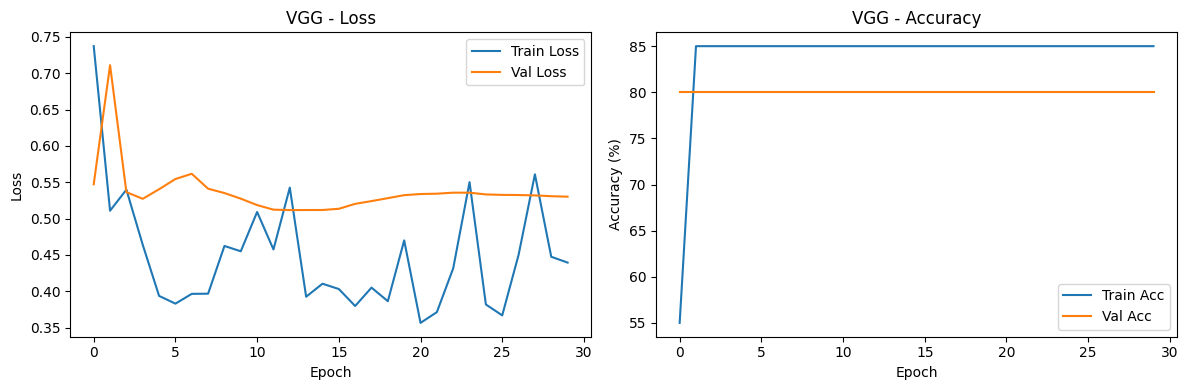


Generating prediction visualizations...


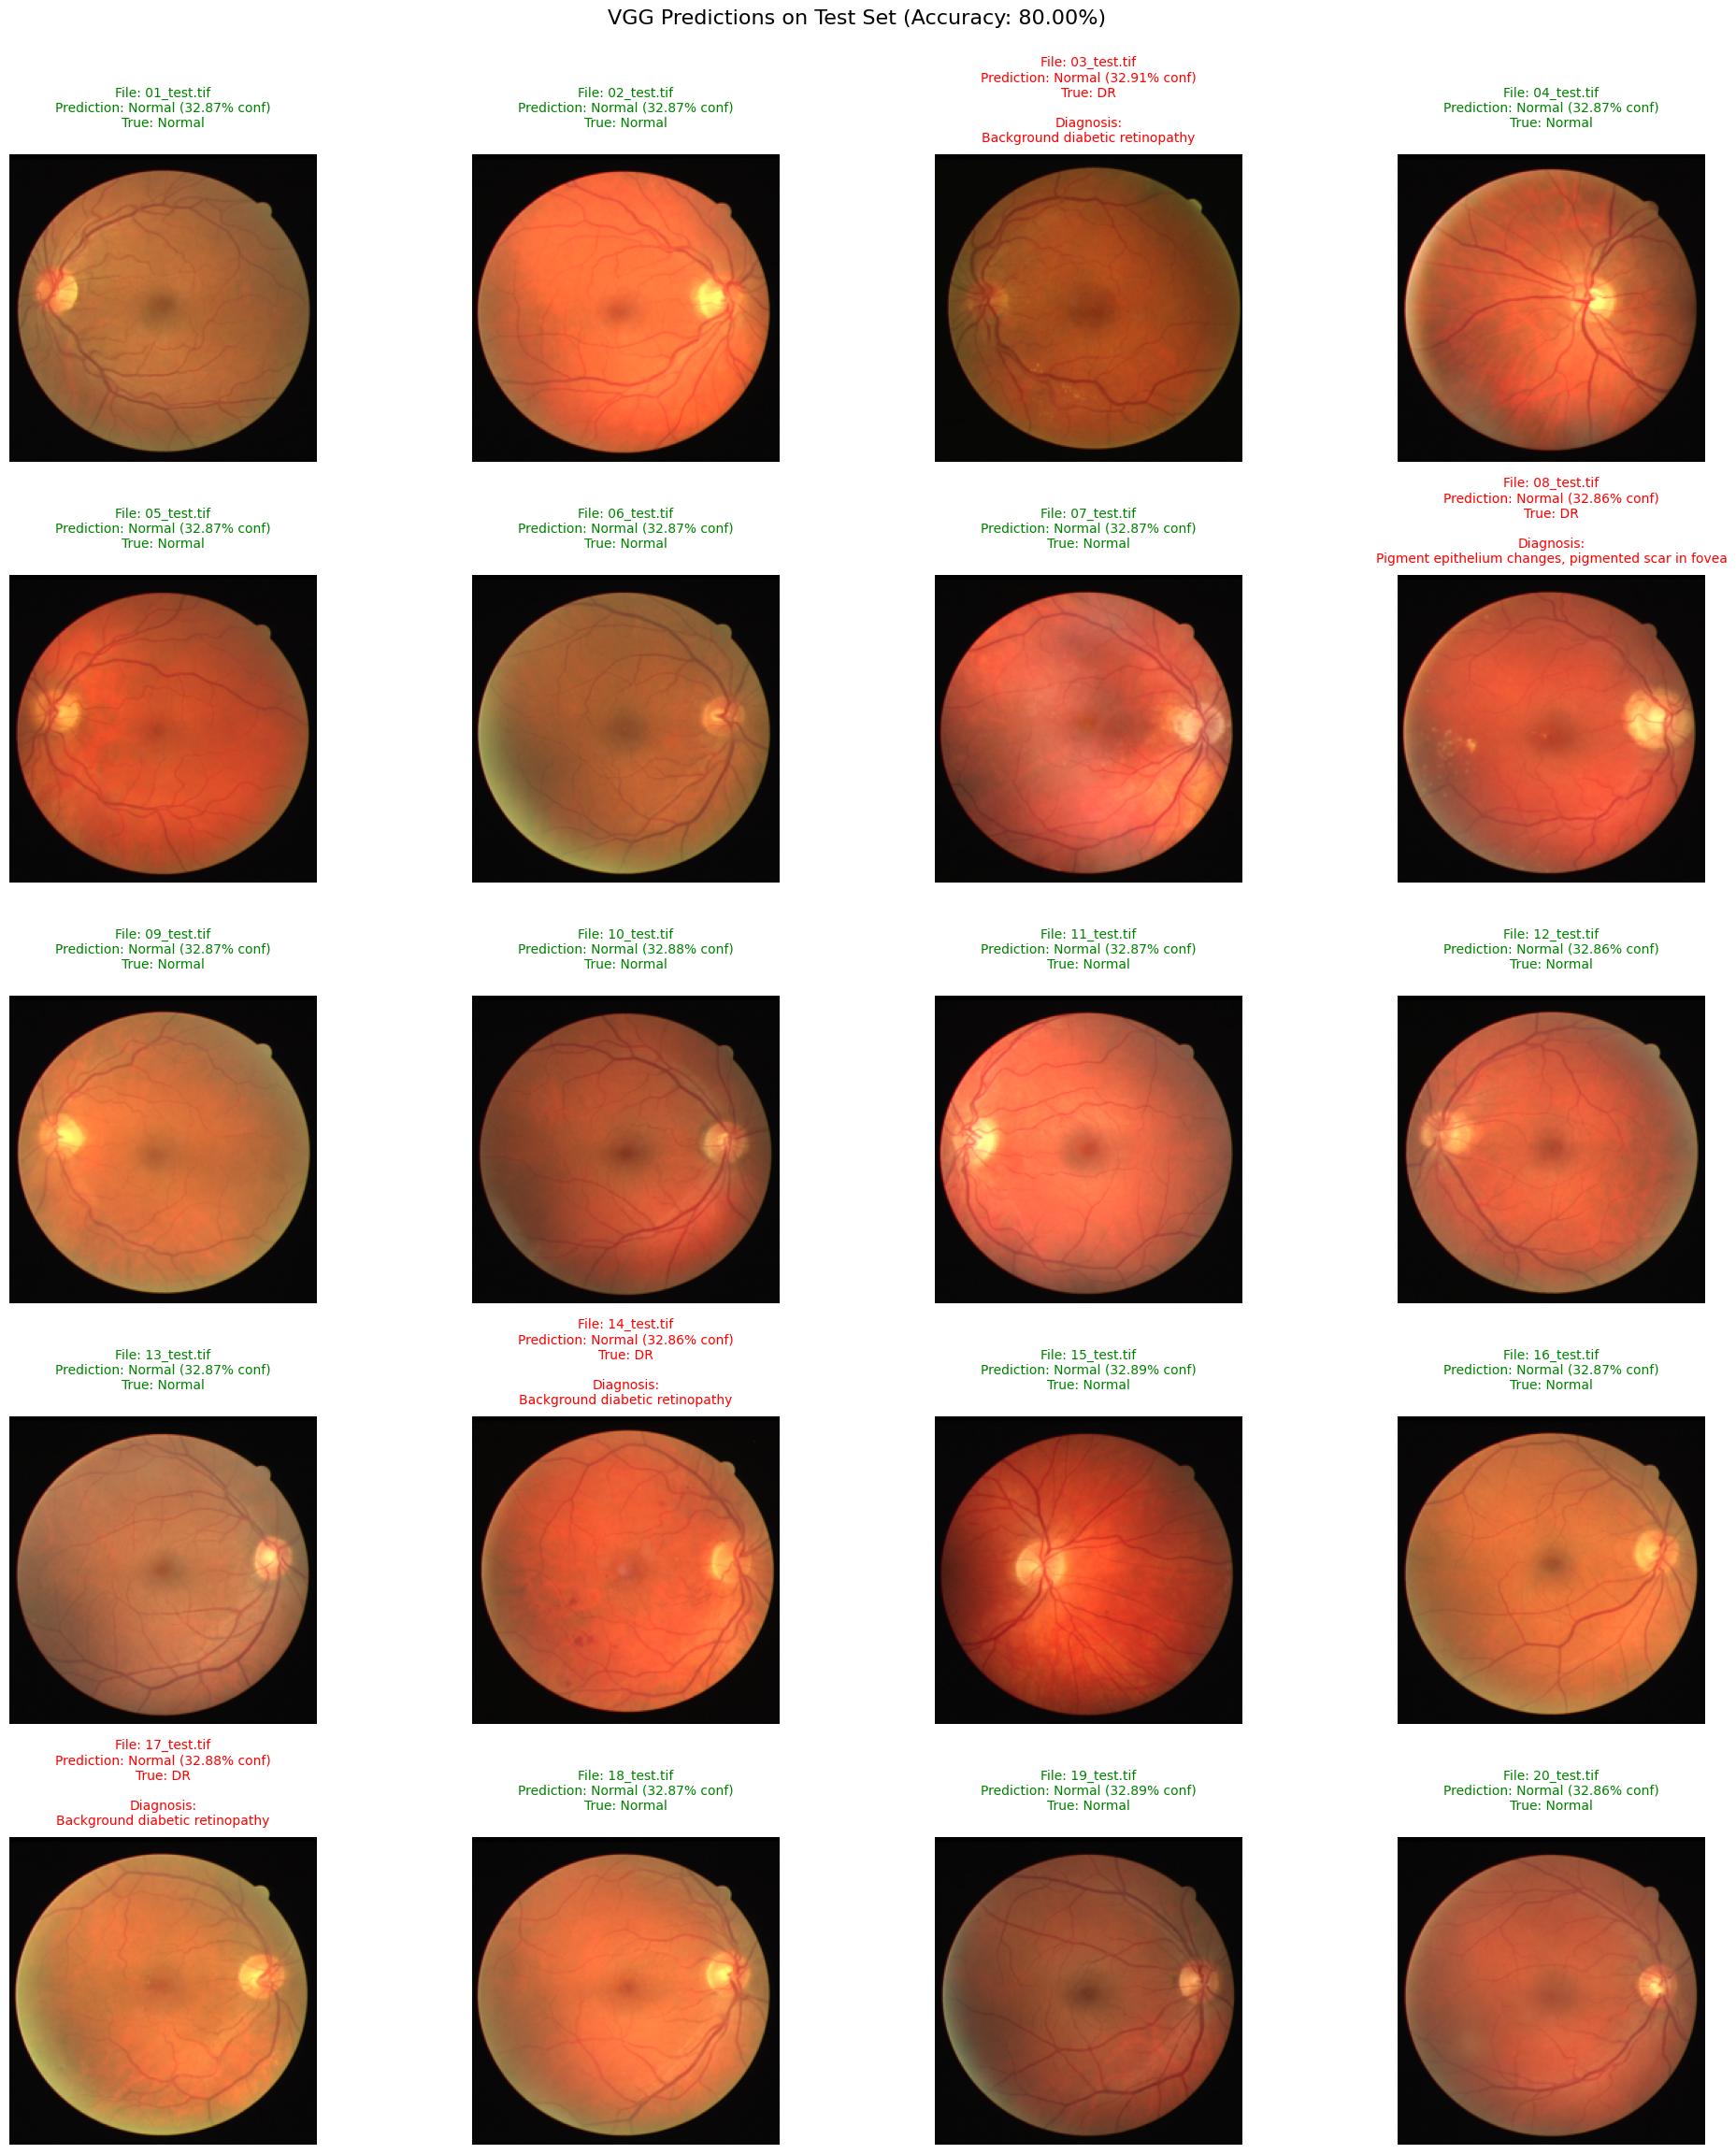


Model Performance:
Accuracy: 80.00%
Sensitivity: 0.00%
Specificity: 100.00%


In [52]:
# Example usage
if __name__ == "__main__":
    model, history, results = main(
        data_path=path,  # Using the path from kagglehub download
        model_type='vgg',  # or 'vgg'
        batch_size=8,
        epochs=30
    )